# Imports

In [118]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 21.3 MB/s eta 0:00:00


In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import numpy as np
from tqdm import tqdm
import pandas as pd
import nltk
from collections import Counter
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from tqdm import tqdm
import math
import gc
from torch.cuda.amp import autocast, GradScaler
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

## Vocabulary

In [2]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                if frequencies[word] >= self.freq_threshold:
                    if word not in self.stoi:
                        self.stoi[word] = idx
                        self.itos[idx] = word
                        idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]
# 3. Dataset and DataLoader


## Model 1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class AudioEncoder(nn.Module):
    def __init__(self, n_mels, d_model, nhead, num_encoder_layers, dim_feedforward):
        super(AudioEncoder, self).__init__()
        self.conv = nn.Conv1d(n_mels, d_model, kernel_size=3, padding=1)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward), 
            num_layers=num_encoder_layers
        )
        self.positional_encoding = PositionalEncoding(d_model)

    def forward(self, src):
        # src shape: (batch_size, time_steps, n_mels)
        src = self.conv(src.transpose(1, 2))  # (batch_size, d_model, time_steps)
        src = src.transpose(1, 2)  # (batch_size, time_steps, d_model)
        src = self.positional_encoding(src)  # (batch_size, time_steps, d_model)
        output = self.transformer_encoder(src.transpose(0, 1))  # (time_steps, batch_size, d_model)
        return output.transpose(0, 1)  # (batch_size, time_steps, d_model)

class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward):
        super(CaptionDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
            num_layers=num_decoder_layers
        )
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory):
        # tgt shape: (batch_size, tgt_len)
        tgt = self.embedding(tgt)  # (batch_size, tgt_len, d_model)
        tgt = self.positional_encoding(tgt.transpose(0, 1))  # (tgt_len, batch_size, d_model)
        output = self.transformer_decoder(tgt, memory.transpose(0, 1))  # (tgt_len, batch_size, d_model)
        output = self.fc_out(output)  # (tgt_len, batch_size, vocab_size)
        return output.transpose(0, 1)  # (batch_size, tgt_len, vocab_size)

class AudioCaptioningModel(nn.Module):
    def __init__(self, n_mels, vocab_size, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048):
        super(AudioCaptioningModel, self).__init__()
        self.encoder = AudioEncoder(n_mels, d_model, nhead, num_encoder_layers, dim_feedforward)
        self.decoder = CaptionDecoder(vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward)
        self.d_model = d_model
        self.vocab_size = vocab_size
            
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        memory = self.encoder(src)
        
        # Shift the target to the left (remove the last token for input)
        tgt_input = tgt[:, :-1]
        tgt_expected = tgt[:, 1:]  # The expected output, shifted by one
    
        # Embed and apply positional encoding to the target sequence
        tgt_embedded = self.decoder.embedding(tgt_input)
        tgt_embedded = self.decoder.positional_encoding(tgt_embedded.transpose(0, 1))  # (tgt_len, batch_size, d_model)
    
        # Generate a causal mask for the decoder (prevent attending to future tokens)
        tgt_len = tgt_input.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(tgt.device)  # (tgt_len, tgt_len)
    
        # Generate padding mask (optional if padding is used)
        if hasattr(self.decoder.embedding, 'padding_idx') and self.decoder.embedding.padding_idx is not None:
            # Create the padding mask as a boolean tensor
            tgt_padding_mask = (tgt_input == self.decoder.embedding.padding_idx)  # (batch_size, tgt_len)
        else:
            tgt_padding_mask = None
    
        # Apply the transformer decoder
        output = self.decoder.transformer_decoder(
            tgt_embedded, 
            memory.transpose(0, 1),
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )
        
        # Apply the final linear layer
        output = self.decoder.fc_out(output)  # (tgt_len, batch_size, vocab_size)
        return output.transpose(0, 1)  # (batch_size, tgt_len, vocab_size)


## Model 2

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.gru = nn.GRU(input_size=256*input_dim//16, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True)

    def forward(self, x):
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        b, c, t, f = x.size()
        x = x.permute(0, 2, 1, 3).contiguous().view(b, t, c * f)
        output, hidden = self.gru(x)
        return output, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1
        return outputs

## Infer Transformer

In [86]:
import torch
import torchaudio
import torch.nn.functional as F

def infer_transformer(audio_path, model, vocab, fixed_length=160000, n_mels=128, target_sample_rate=16000, max_caption_length=50, device='cuda'):
    # Load and preprocess the audio
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0, keepdim=True)  # Convert to mono
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)

    # Pad or truncate waveform to fixed length
    if waveform.size(1) > fixed_length:
        waveform = waveform[:, :fixed_length]
    else:
        pad_length = fixed_length - waveform.size(1)
        waveform = F.pad(waveform, (0, pad_length))

    # Convert waveform to mel spectrogram
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sample_rate,
        n_mels=n_mels
    )(waveform)

    # Prepare the input tensor for the model
    mel_spectrogram = mel_spectrogram.squeeze(0).T.unsqueeze(0).to(device)  # (1, time_steps, n_mels)

    # Set the model to evaluation mode
    model.eval()

    # Initialize the input for the decoder (start with the <SOS> token)
    tgt_input = torch.tensor([[vocab.stoi['<SOS>']]], device=device)  # Shape: (1, 1)

    # Run the encoder
    with torch.no_grad():
        memory = model.encoder(mel_spectrogram)

    # Initialize a list to store generated tokens
    generated_tokens = []

    # Generate the caption using the decoder
    for _ in range(max_caption_length):
        # Embed and apply positional encoding to the target input
        tgt_embedded = model.decoder.embedding(tgt_input)
        tgt_embedded = model.decoder.positional_encoding(tgt_embedded.transpose(0, 1))  # (tgt_len, batch_size, d_model)

        # Generate a causal mask for the decoder
        tgt_len = tgt_input.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)  # (tgt_len, tgt_len)

        # Run the decoder
        output = model.decoder.transformer_decoder(
            tgt_embedded,
            memory.transpose(0, 1),
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=None  # No padding mask needed during inference
        )

        # Apply the final linear layer to get logits
        output = model.decoder.fc_out(output)  # (tgt_len, batch_size, vocab_size)

        # Get the predicted token for the current step
        next_token = output[-1, :, :].argmax(-1).unsqueeze(0)  # Shape: (1, batch_size)

        # Transpose next_token to match tgt_input shape for concatenation
        next_token = next_token.transpose(0, 1)  # Shape: (batch_size, 1)

        # Append the predicted token to the input sequence and to the generated tokens
        tgt_input = torch.cat([tgt_input, next_token], dim=1)
        generated_tokens.append(next_token.item())

        # Stop if <EOS> token is generated
        if next_token.item() == vocab.stoi['<EOS>']:
            break

    # Convert the generated sequence of tokens to words
    generated_caption = [vocab.itos[token] for token in generated_tokens]

    return ' '.join(generated_caption)


## Infer RNN

In [87]:
def infer_rnn(model, audio_path, vocab, device, fixed_length=160000, n_mels=128, target_sample_rate=16000, max_length=50):
    # Preprocessing steps
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sample_rate,
        n_mels=n_mels
    )
    
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0, keepdim=True)  # Convert to mono
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)

    if waveform.size(1) > fixed_length:
        waveform = waveform[:, :fixed_length]
    else:
        pad_length = fixed_length - waveform.size(1)
        waveform = F.pad(waveform, (0, pad_length))

    mel_spectrogram = mel_spectrogram(waveform)
    mel_spectrogram = mel_spectrogram.squeeze(0).T.unsqueeze(0).to(device)  # Transpose to match (time, n_mels) and add batch dimension

    model.eval()
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(mel_spectrogram)
        input_token = torch.tensor([vocab.stoi["<SOS>"]]).to(device)
        caption = []

        for _ in range(max_length):
            output, hidden = model.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1)
            if top1.item() == vocab.stoi["<EOS>"]:
                break
            caption.append(top1.item())
            input_token = top1

    caption_text = ' '.join([vocab.itos[token] for token in caption])
    return caption_text

## Test Functions

In [81]:
def test_transformer_model(model, test_dataset, vocab, batch_size=32, device='cuda'):
    model.eval()
    model.to(device)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    all_predictions = []
    all_references = []
    bleu_scores = []
    
    with torch.no_grad():
        for batch in test_loader:
            audio_paths = batch['path']  # Paths to audio files
            original_captions = batch['original_caption']  # Ground truth captions
            
            for i, audio_path in enumerate(audio_paths):
                predicted_caption = infer_transformer(audio_path, model, vocab, device=device)
                
                all_predictions.append(predicted_caption)
                all_references.append(original_captions[i])
                
                reference = [original_captions[i].split()]
                prediction = predicted_caption.split()
                bleu_score = sentence_bleu(reference, prediction)
                bleu_scores.append(bleu_score)
    
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    
    return avg_bleu_score, list(zip(all_predictions, all_references)), bleu_scores

In [84]:
def test_rnn_model(model, test_dataset, vocab, batch_size=32, device='cuda'):
    model.eval()
    model.to(device)
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    all_predictions = []
    all_references = []
    bleu_scores = []
    
    with torch.no_grad():
        for batch in test_loader:
            audio_paths = batch['path']  # Paths to audio files
            original_captions = batch['original_caption']  # Ground truth captions
            
            for i, audio_path in enumerate(audio_paths):
                predicted_caption = infer_rnn(model, audio_path, vocab, device=device)
                
                all_predictions.append(predicted_caption)
                all_references.append(original_captions[i])
                
                reference = [original_captions[i].split()]
                prediction = predicted_caption.split()
                bleu_score = sentence_bleu(reference, prediction)
                bleu_scores.append(bleu_score)
    
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    
    return avg_bleu_score, list(zip(all_predictions, all_references)), bleu_scores

In [74]:
def plot_bleu_score_distribution(bleu_scores):
    plt.figure(figsize=(8, 6))
    plt.hist(bleu_scores, bins=10, color='c', edgecolor='black')
    plt.title("BLEU Score Distribution")
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [75]:
def display_predictions(predictions, n=5):
    df = pd.DataFrame(predictions, columns=['Predicted', 'Reference'])
    
    for i in range(n):
        print(f"Sample {i + 1}:")
        print(f"Predicted Caption: {df.iloc[i]['Predicted']}")
        print(f"Reference Caption: {df.iloc[i]['Reference']}")
        print('-' * 50)

In [76]:
def plot_word_cloud(predicted_captions):
    all_predicted_text = ' '.join(predicted_captions)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_predicted_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Predicted Captions")
    plt.show()

## Dataset

In [44]:
class MusicCapsDataset(Dataset):
    def __init__(self, csv_files, audio_dir, vocab, fixed_length=160000, n_mels=128, target_sample_rate=16000):
        # Merge all CSVs into a single DataFrame
        dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]
        self.data = pd.concat(dataframes, ignore_index=True)
        self.data = self.data.sample(frac=1).reset_index(drop=True)

        print(self.data.shape)
        self.audio_dir = audio_dir
        self.vocab = vocab
        self.fixed_length = fixed_length
        self.n_mels = n_mels
        self.target_sample_rate = target_sample_rate
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_mels=self.n_mels
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_id = self.data.iloc[idx]['ytid']
        audio_path = os.path.join(self.audio_dir, f"{audio_id}.wav")
        caption = self.data.iloc[idx]['caption']
        waveform, sample_rate = torchaudio.load(audio_path)
        waveform = waveform.mean(dim=0, keepdim=True)  # Convert to mono
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)

        if waveform.size(1) > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]
        else:
            pad_length = self.fixed_length - waveform.size(1)
            waveform = F.pad(waveform, (0, pad_length))

        mel_spectrogram = self.mel_spectrogram(waveform)

        numericalized_caption = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]

        sample = {
            'audio': mel_spectrogram.squeeze(0).T,  # Transpose to match (time, n_mels)
            'caption': torch.tensor(numericalized_caption),
            'original_caption': caption,
            'path': audio_path,
            'sample_rate': self.target_sample_rate
        }
        return sample

def pad_sequence(batch):
    batch = [item['caption'] for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
    return batch

def collate_fn(data):
    audio = [item['audio'] for item in data]
    captions = [item['caption'] for item in data]

    # Pad audio sequences to the same length
    audio_lengths = [len(a) for a in audio]
    max_audio_length = max(audio_lengths)
    padded_audio = torch.zeros(len(audio), max_audio_length, audio[0].size(1))
    for i, a in enumerate(audio):
        padded_audio[i, :len(a), :] = a

    # Pad caption sequences to the same length
    caption_lengths = [len(c) for c in captions]
    max_caption_length = max(caption_lengths)
    padded_captions = torch.zeros(len(captions), max_caption_length).long()
    for i, c in enumerate(captions):
        padded_captions[i, :len(c)] = c

    original_captions = [item['original_caption'] for item in data]
    paths = [item['path'] for item in data]

    return {'audio': padded_audio, 'caption': padded_captions, 'original_caption': original_captions, 'path': paths}

## Initialize Test Set

In [78]:
csv_files = ['musiccaps-public.csv']
audio_dir = './music_data/music_data'
freq_threshold = 5

dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]
df = pd.concat(dataframes, ignore_index=True)

# Split dataset
base_dataset = MusicCapsDataset(csv_files=csv_files, audio_dir=audio_dir, vocab=vocab1)  # Pass vocab=None for now

train_size = int(0.8 * len(base_dataset))
val_size = math.trunc((len(base_dataset) - train_size) / 2)
random_seed = 42
generator = torch.Generator().manual_seed(random_seed)
base_train_dataset, base_val_dataset, base_test_dataset = random_split(base_dataset, [train_size, val_size + 1, val_size], generator)

(5391, 9)


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [79]:
csv_files = ['mayo_final_final.csv', 'musiccaps-public.csv']
audio_dir = './music_data/music_data'
freq_threshold = 5

dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]
df = pd.concat(dataframes, ignore_index=True)

# Split dataset
full_dataset = MusicCapsDataset(csv_files=csv_files, audio_dir=audio_dir, vocab=vocab2)  # Pass vocab=None for now

train_size = int(0.8 * len(full_dataset))
val_size = math.trunc((len(full_dataset) - train_size) / 2)
random_seed = 42
generator = torch.Generator().manual_seed(random_seed)
full_train_dataset, full_val_dataset, full_test_dataset = random_split(full_dataset, [train_size, val_size + 1, val_size], generator)

(6312, 11)


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


## Load Vocab

In [71]:
import torch
vocab1 = torch.load('vocab1.pt')
print(len(vocab1))
vocab2 = torch.load('vocab2.pt')
print(len(vocab2))

1835
2076


/tmp/ipykernel_144/2928801910.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab1 = torch.load('vocab1.pt')
/tmp/ipykernel_144/2928801910.py:4: FutureWarning: You are

## Initalize Models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
INPUT_DIM = 128
OUTPUT_DIM = len(vocab1)
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
EMB_DIM = 256

encoder1 = Encoder(INPUT_DIM, ENC_HIDDEN_DIM, ENC_LAYERS, ENC_DROPOUT)
decoder1 = Decoder(OUTPUT_DIM, EMB_DIM, DEC_HIDDEN_DIM, DEC_LAYERS, DEC_DROPOUT)
rnn1 = Seq2Seq(encoder1, decoder1, device).to(device)

rnn1.load_state_dict(torch.load('./rnn_exp1.pt'))

/tmp/ipykernel_144/2444393656.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn1.load_state_dict(torch.load('./rnn_exp1.pt'))


<All keys matched successfully>

In [11]:
infer_rnn(rnn1, './music_data/music_data/_5fwnVeZbvI.wav', vocab1, device)

mel_spectrogram.shape=torch.Size([1, 801, 128])
encoder_outputs.shape=torch.Size([1, 51, 1024])
hidden.shape=torch.Size([4, 1, 512])


'voices passion ending suspenseful partner soap ping credits crickets credits tranquil presentation her alternates down alternates alternates only alternates alternates alternates alternates alternates appears fade serves hard-hitting groups pluck snapping snapping super down sides gets machine microphone yoga switches microphone arabic switches shattering actual subdued switches explosions joyful who surface'

In [12]:
INPUT_DIM = 128
OUTPUT_DIM = len(vocab1)
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
EMB_DIM = 256

encoder2 = Encoder(INPUT_DIM, ENC_HIDDEN_DIM, ENC_LAYERS, ENC_DROPOUT)
decoder2 = Decoder(OUTPUT_DIM, EMB_DIM, DEC_HIDDEN_DIM, DEC_LAYERS, DEC_DROPOUT)
rnn2 = Seq2Seq(encoder2, decoder2, device).to(device)

rnn2.load_state_dict(torch.load('./rnn_exp2.pt'))

/tmp/ipykernel_144/3177753712.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn2.load_state_dict(torch.load('./rnn_exp2.pt'))


<All keys matched successfully>

In [15]:
infer_rnn(rnn2, './music_data/music_data/_5fwnVeZbvI.wav', vocab1, device)

mel_spectrogram.shape=torch.Size([1, 801, 128])
encoder_outputs.shape=torch.Size([1, 51, 1024])
hidden.shape=torch.Size([4, 1, 512])


'this is an electronic music piece . there is a male vocalist singing in a <UNK> manner . the melody is being played by the keyboard . the is a keyboard playing the background . the rhythm is provided by a electronic drum beat . the atmosphere is sentimental .'

In [17]:
INPUT_DIM = 128
OUTPUT_DIM = len(vocab2)
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
EMB_DIM = 256

encoder3 = Encoder(INPUT_DIM, ENC_HIDDEN_DIM, ENC_LAYERS, ENC_DROPOUT)
decoder3 = Decoder(OUTPUT_DIM, EMB_DIM, DEC_HIDDEN_DIM, DEC_LAYERS, DEC_DROPOUT)
rnn3 = Seq2Seq(encoder3, decoder3, device).to(device)

rnn3.load_state_dict(torch.load('./rnn_exp3.pt'))

/tmp/ipykernel_144/4114176761.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn3.load_state_dict(torch.load('./rnn_exp3.pt'))


<All keys matched successfully>

In [19]:
infer_rnn(rnn3, './music_data/music_data/_5fwnVeZbvI.wav', vocab2, device)

mel_spectrogram.shape=torch.Size([1, 801, 128])
encoder_outputs.shape=torch.Size([1, 51, 1024])
hidden.shape=torch.Size([4, 1, 512])


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


'a male singer sings this cool melody with backup singers in vocal harmony . the song is medium tempo with a groovy drumming rhythm , groovy bass line , keyboard accompaniment and a strong bass line . the song is a and dance rhythm . the song is a modern'

In [61]:
transformer1 = AudioCaptioningModel(
    n_mels=128, 
    vocab_size=len(vocab1), 
    d_model=512, 
    nhead=8, 
    num_encoder_layers=6, 
    num_decoder_layers=6, 
    dim_feedforward=2048
).to(device)

transformer1.load_state_dict(torch.load('./checkpoints5/epoch_4_loss_5.2308470922357895'))

/tmp/ipykernel_144/3329138813.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer1.load_state_dict(torch.load('./checkpoints5/epoch_4_loss_5.2308470922357895'))

<All keys matched successfully>

In [63]:
infer_transformer('./music_data/music_data/_5fwnVeZbvI.wav', transformer1, vocab1)

torch.Size([2, 958728])


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


'. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

In [65]:
transformer2 = AudioCaptioningModel(
    n_mels=128, 
    vocab_size=len(vocab1), 
    d_model=512, 
    nhead=8, 
    num_encoder_layers=6, 
    num_decoder_layers=6, 
    dim_feedforward=2048
).to(device)

transformer2.load_state_dict(torch.load('./checkpoints5/epoch_7_loss_2.250007292803596'))

/tmp/ipykernel_144/630907090.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer2.load_state_dict(torch.load('./checkpoints5/epoch_7_loss_2.250007292803596'))


<All keys matched successfully>

In [67]:
infer_transformer('./music_data/music_data/_5fwnVeZbvI.wav', transformer2, vocab1)

torch.Size([2, 958728])


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


'this is a <UNK> music piece . there is a male vocalist singing melodically in the lead . the melody is being played by the piano and the bass guitar . the rhythm is being played by a <UNK> acoustic drum beat . the atmosphere is urban . this piece'

In [69]:
transformer3 = AudioCaptioningModel(
    n_mels=128, 
    vocab_size=len(vocab2), 
    d_model=512, 
    nhead=8, 
    num_encoder_layers=6, 
    num_decoder_layers=6, 
    dim_feedforward=2048
).to(device)

transformer3.load_state_dict(torch.load('./checkpoints5/epoch_7_loss_2.4016524076461794'))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_144/3868563968.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

<All keys matched successfully>

## Run Tests

In [88]:
rnn1_avg_bleu, rnn1_predictions, rnn1_bleu_scores = test_rnn_model(rnn1, base_test_dataset, vocab1)

In [89]:
rnn2_avg_bleu, rnn2_predictions, rnn2_bleu_scores = test_rnn_model(rnn2, base_test_dataset, vocab1)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.

In [91]:
rnn3_avg_bleu, rnn3_predictions, rnn3_bleu_scores = test_rnn_model(rnn3, full_test_dataset, vocab2)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.

In [96]:
transformer1_avg_bleu, transformer1_predictions, transformer1_bleu_scores = test_transformer_model(transformer1, base_test_dataset, vocab1)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.

In [97]:
transformer2_avg_bleu, transformer2_predictions, transformer2_bleu_scores = test_transformer_model(transformer2, base_test_dataset, vocab1)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.

In [98]:
transformer3_avg_bleu, transformer3_predictions, transformer3_bleu_scores = test_transformer_model(transformer3, full_test_dataset, vocab2)

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.

## RNN Experiment 1

In [127]:
print(f'{rnn1_avg_bleu=}')

rnn1_avg_bleu=1.6892436109401173e-232


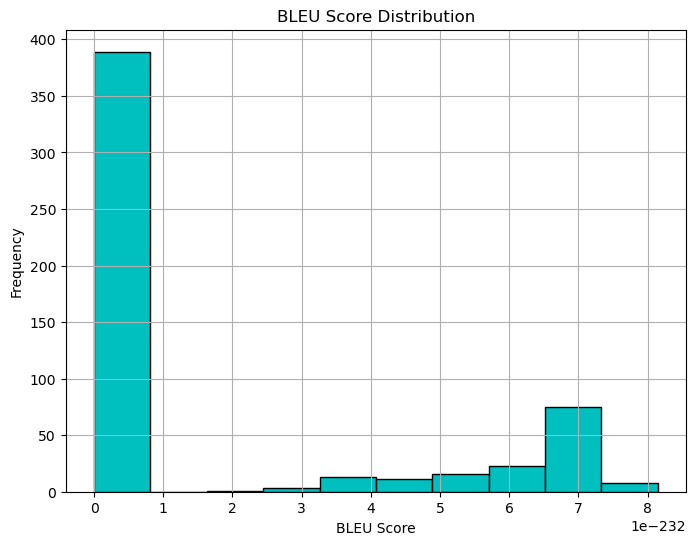

In [103]:
plot_bleu_score_distribution(rnn1_bleu_scores)

In [109]:
display_predictions(rnn1_predictions, n=5)

Sample 1:
Predicted Caption: body actual horror uplifting didgeridoos ceremony event kids image backed those sleep opera sleep era era era compound royalty trip videos stop videos stroke hammer gets famous sung who continuously royalty holiday raspy believe many kid sombre sombre sombre moment sombre peak sci-fi sci-fi ground beach tranquil unpleasant presentation still
Reference Caption: This music is an animated instrumental. The tempo is fast with a lively cello bass line , viola and violin harmony with a  lead strung instrument which is either an Auto Harp or electric guitar. There is a child’s voice superimposed on the music with incoherent words and a lot of static. The music is lively, intense,playful, fun, cheerful, animated and breezy. This music is an animated Pop.
--------------------------------------------------
Sample 2:
Predicted Caption: voices passion passion passion passion pad reverberating generic vibrations piece targeted stuttering reversed '' hissing device video

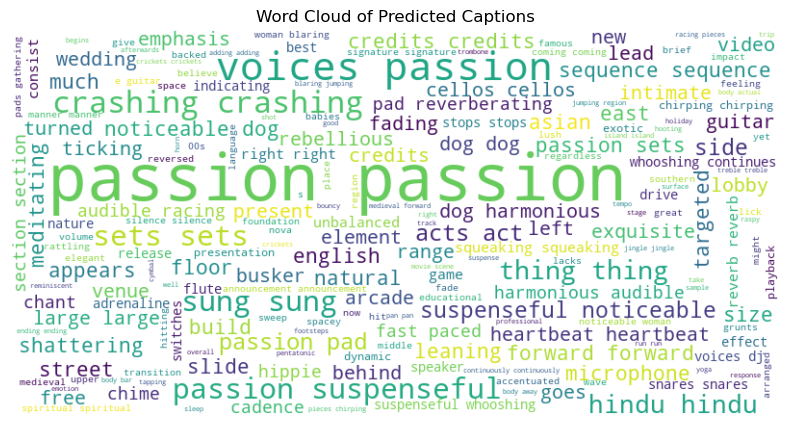

In [120]:
rnn1_predicted_captions = [p[0] for p in rnn1_predictions]
plot_word_cloud(rnn1_predicted_captions)

## RNN Experiment 2

In [128]:
print(f'{rnn2_avg_bleu=}')

rnn2_avg_bleu=2.9530715299432934e-158


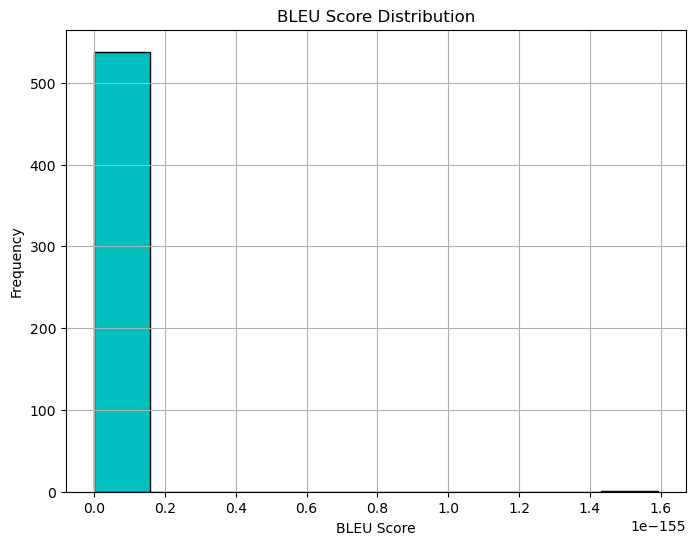

In [104]:
plot_bleu_score_distribution(rnn2_bleu_scores)

In [110]:
display_predictions(rnn2_predictions, n=5)

Sample 1:
Predicted Caption: sleep used pedal uplifting genre were tribal organ applied applied vibrato want want players players players island island great speaks great afterwards afterwards jam holding holding 80s coming bizarre want bizarre great medieval cellos great afterwards afterwards beat-making afterwards fat death afterwards fat bizarre ground bizarre bizarre bizarre bizarre bizarre
Reference Caption: This music is an animated instrumental. The tempo is fast with a lively cello bass line , viola and violin harmony with a  lead strung instrument which is either an Auto Harp or electric guitar. There is a child’s voice superimposed on the music with incoherent words and a lot of static. The music is lively, intense,playful, fun, cheerful, animated and breezy. This music is an animated Pop.
--------------------------------------------------
Sample 2:
Predicted Caption: man harp bit bit bowed bowed cellos bowed common reverberant reverberant reverberant guzheng spanish trombone

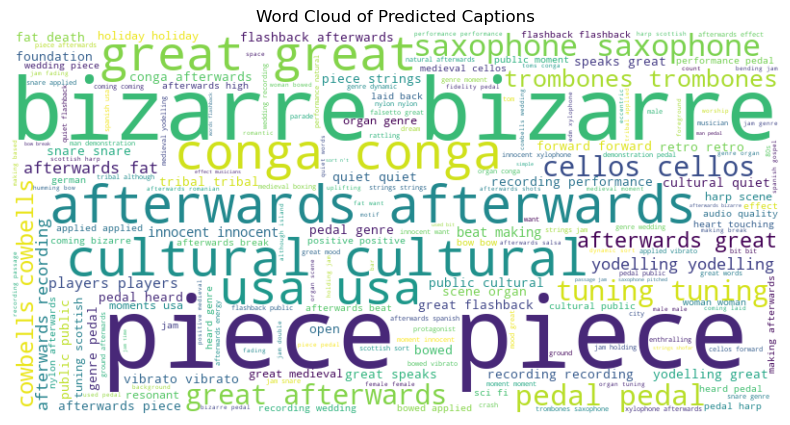

In [121]:
rnn2_predicted_captions = [p[0] for p in rnn2_predictions]
plot_word_cloud(rnn2_predicted_captions)

## RNN Experiment 3

In [129]:
print(f'{rnn3_avg_bleu=}')

rnn3_avg_bleu=0.020031793429588045


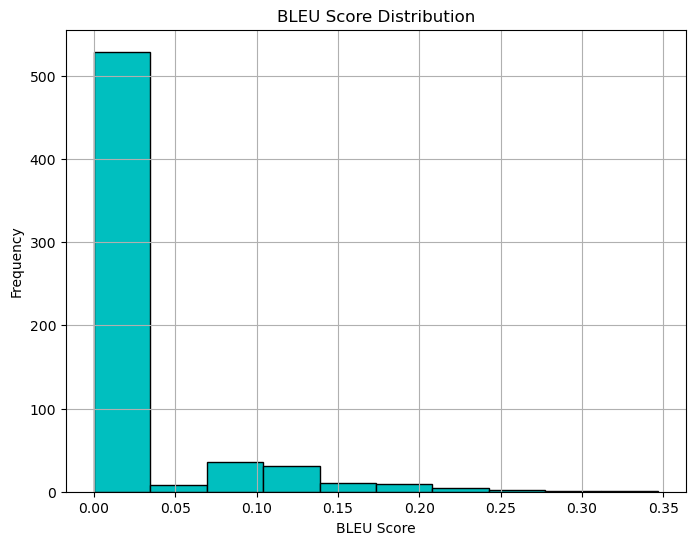

In [105]:
plot_bleu_score_distribution(rnn3_bleu_scores)

In [112]:
display_predictions(rnn3_predictions, n=5)

Sample 1:
Predicted Caption: a soothing melody that flows like a gentle embrace , creating a sense of longing and <UNK> . the for a reflective , , perfect for moments of reflection and <UNK> .
Reference Caption: A male Latin singer sings this romantic melody. The song is medium tempo with an acoustic guitar accompaniment with no other instrumentation. The song is emotional and passionate. The audio quality is poor.
--------------------------------------------------
Sample 2:
Predicted Caption: a male vocalist sings this enthusiastic latin song . the tempo is fast with a drumming , groovy bass lines , keyboard accompaniment , the song is a , , , , , , , , , , , , , , , , , , , and , <UNK>
Reference Caption: A group of male vocalists sing this happy, upbeat country /bluegrass song. The tempo is fast with vigorous and animated acoustic guitar, banjo, mandolin and auto harp lead and harmony. The song is a live performance with ambient sounds of clapping, cheering and people talking. This s

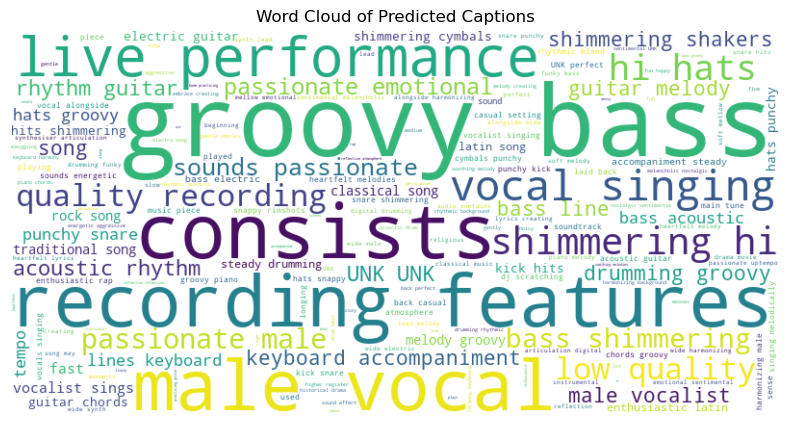

In [122]:
rnn3_predicted_captions = [p[0] for p in rnn3_predictions]
plot_word_cloud(rnn3_predicted_captions)

## Transformer Experiment 1

In [130]:
print(f'{transformer1_avg_bleu=}')

transformer1_avg_bleu=1.1439829894496005e-233


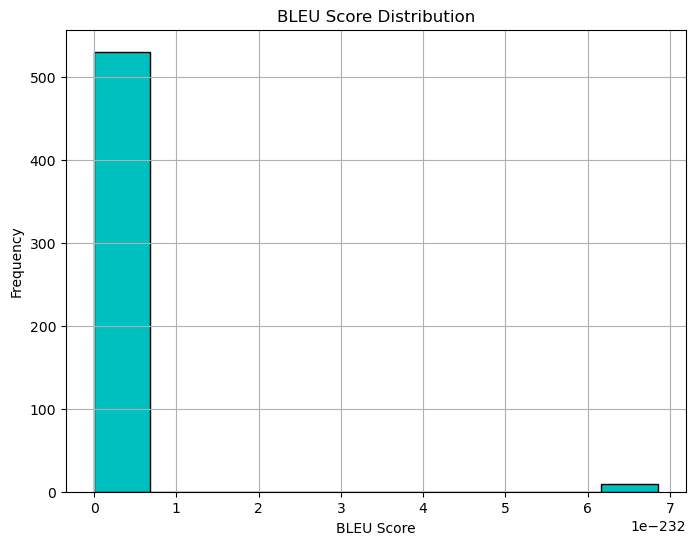

In [106]:
plot_bleu_score_distribution(transformer1_bleu_scores)

In [113]:
display_predictions(transformer1_predictions, n=5)

Sample 1:
Predicted Caption: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Reference Caption: This music is an animated instrumental. The tempo is fast with a lively cello bass line , viola and violin harmony with a  lead strung instrument which is either an Auto Harp or electric guitar. There is a child’s voice superimposed on the music with incoherent words and a lot of static. The music is lively, intense,playful, fun, cheerful, animated and breezy. This music is an animated Pop.
--------------------------------------------------
Sample 2:
Predicted Caption: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Reference Caption: The low quality recording features a bright brass melody played in a reverberant space. The recording is in mono and it is a bit noisy.
--------------------------------------------------
Sample 3:
Predicted Caption: . . . . . . . . . . . . . . . . . . . . . .

In [133]:
transformer1_predicted_captions = [p[0] for p in transformer1_predictions]
plot_word_cloud(transformer1_predicted_captions)

ValueError: We need at least 1 word to plot a word cloud, got 0.

## Transformer Experiment 2

In [131]:
print(f'{transformer2_avg_bleu=}')

transformer2_avg_bleu=0.006838306104705887


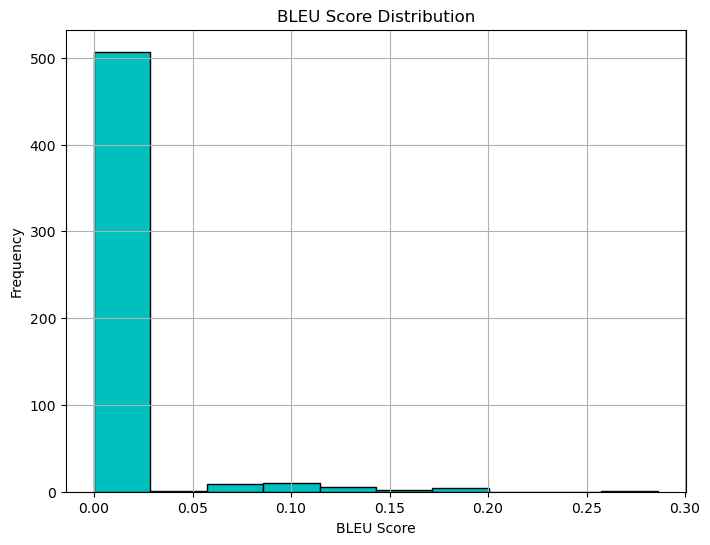

In [107]:
plot_bleu_score_distribution(transformer2_bleu_scores)

In [114]:
display_predictions(transformer2_predictions, n=5)

Sample 1:
Predicted Caption: this is a <UNK> music piece . there is a male vocalist singing melodically in the lead . the melody is being played by the acoustic guitar and the bass guitar in the background . the rhythm is provided by a slow tempo acoustic drum beat . the atmosphere is
Reference Caption: This music is an animated instrumental. The tempo is fast with a lively cello bass line , viola and violin harmony with a  lead strung instrument which is either an Auto Harp or electric guitar. There is a child’s voice superimposed on the music with incoherent words and a lot of static. The music is lively, intense,playful, fun, cheerful, animated and breezy. This music is an animated Pop.
--------------------------------------------------
Sample 2:
Predicted Caption: this is a <UNK> music piece . there is a male vocalist singing melodically in the lead . the melody is being played by the piano with the bass guitar playing in the background . the rhythm is provided by a slow tempo acou

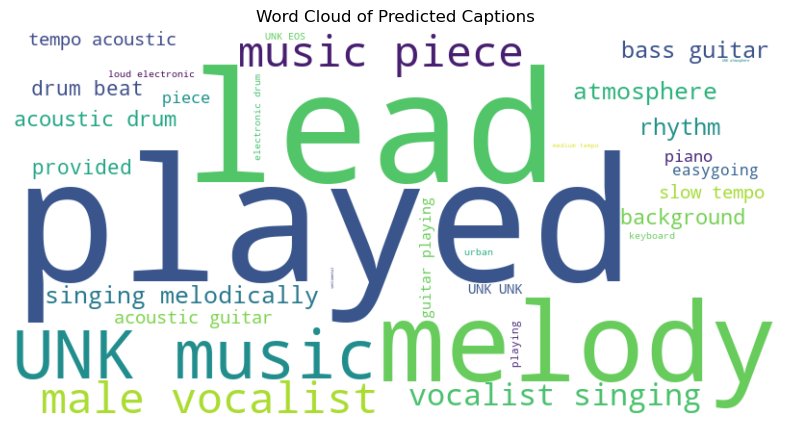

In [124]:
transformer2_predicted_captions = [p[0] for p in transformer2_predictions]
plot_word_cloud(transformer2_predicted_captions)

## Transformer Experiment 3

In [132]:
print(f'{transformer3_avg_bleu=}')

transformer3_avg_bleu=0.020007395202584377


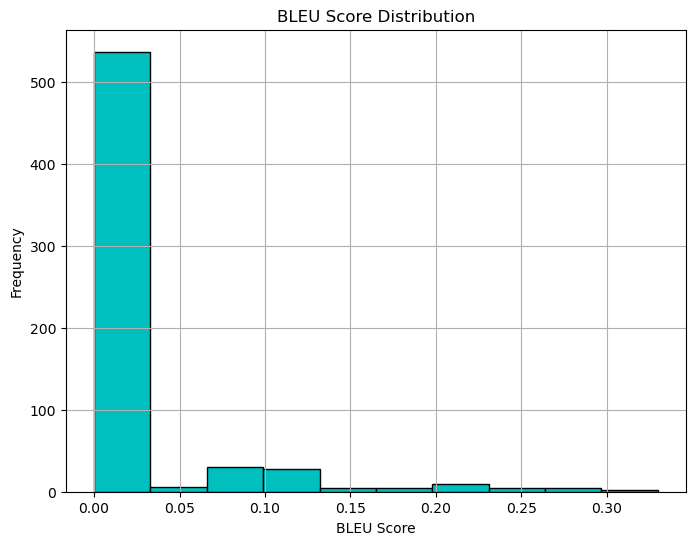

In [108]:
plot_bleu_score_distribution(transformer3_bleu_scores)

In [115]:
display_predictions(transformer3_predictions, n=5)

Sample 1:
Predicted Caption: the low quality recording features a live performance of a rock song and it consists of passionate male vocal singing over acoustic guitar melody , groovy bass , shimmering hi hats and punchy snare hits . it sounds passionate and emotional . <EOS>
Reference Caption: A male Latin singer sings this romantic melody. The song is medium tempo with an acoustic guitar accompaniment with no other instrumentation. The song is emotional and passionate. The audio quality is poor.
--------------------------------------------------
Sample 2:
Predicted Caption: the low quality recording features a live performance of a rock song that consists of flat male vocal singing over groovy bass , punchy snare and shimmering hi hats . the recording is noisy and in mono , as it was probably recorded with a phone . <EOS>
Reference Caption: A group of male vocalists sing this happy, upbeat country /bluegrass song. The tempo is fast with vigorous and animated acoustic guitar, banjo, m

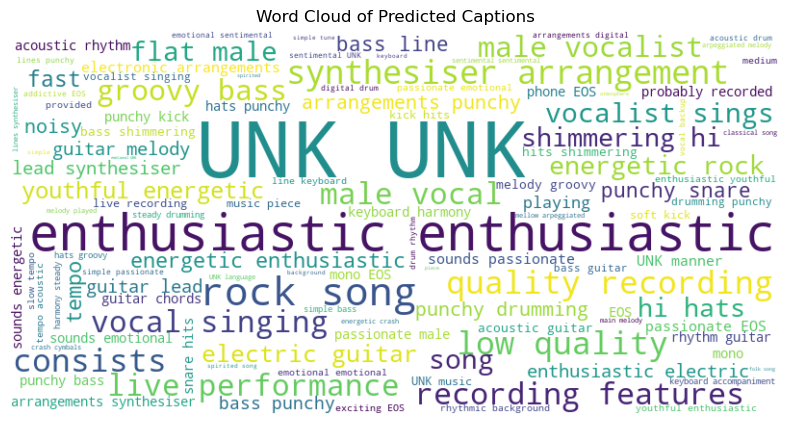

In [125]:
transformer3_predicted_captions = [p[0] for p in transformer3_predictions]
plot_word_cloud(transformer3_predicted_captions)